In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
import shap
from matplotlib import colors
import random
import seaborn as sns

In [2]:
tf.config.list_physical_devices("GPU")
splits = [2, 13, 19, 20, 39, 43, 54, 65, 72, 97]

2023-03-16 16:09:52.114251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:09:52.117313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 16:09:52.117434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [48]:
station = 'OTT'
model_split = splits[5]

with open(f'../data/prepared_data/SW_only_{station}_train_dict.pkl', 'rb') as f:
	sw_train_dict = pickle.load(f)

with open(f'../data/prepared_data/SW_only_{station}_test_dict.pkl', 'rb') as d:
	sw_test_dict = pickle.load(d)

with open(f'../data/prepared_data/combined_{station}_train_dict.pkl', 'rb') as c:
	combined_train_dict = pickle.load(c)

with open(f'../data/prepared_data/combined_{station}_test_dict.pkl', 'rb') as b:
	combined_test_dict = pickle.load(b)

sw_model = load_model(f'models/{station}/CNN_SW_only_split_{model_split}.h5')
combined_model = load_model(f'models/{station}/CNN_version_5_split_{model_split}.h5')

In [49]:
# reducing the amount of the training dataset used to find the shap values
combined_xtrain = combined_train_dict['X']
combined_xtrain = combined_xtrain.reshape((combined_xtrain.shape[0], combined_xtrain.shape[1], combined_xtrain.shape[2], 1))
combined_background = combined_xtrain[np.random.choice(combined_xtrain.shape[0], 1000, replace=False)]

# attempting to use shap
combined_explainer = shap.DeepExplainer(combined_model, combined_background)

sw_xtrain = sw_train_dict['X']
sw_xtrain = sw_xtrain.reshape((sw_xtrain.shape[0], sw_xtrain.shape[1], sw_xtrain.shape[2], 1))
sw_background = sw_xtrain[np.random.choice(sw_xtrain.shape[0], 1000, replace=False)]

# attempting to use shap
sw_explainer = shap.DeepExplainer(sw_model, sw_background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [50]:
storm = 7

sw_results = pd.read_feather(f'outputs/{station}/SW_only_storm_{storm}.feather')
combined_results = pd.read_feather(f'outputs/{station}/version_5_storm_{storm}.feather')

sw_results = sw_results[f'predicted_split_{model_split}']
combined_results = combined_results[f'predicted_split_{model_split}']

In [51]:
sw_storm = sw_test_dict[f'storm_{storm}']['Y']
combined_storm = combined_test_dict[f'storm_{storm}']['Y']

sw_storm = sw_storm.reshape(sw_storm.shape[0], sw_storm.shape[1], sw_storm.shape[2], 1)
combined_storm = combined_storm.reshape(combined_storm.shape[0], combined_storm.shape[1], combined_storm.shape[2], 1)

combined_shap_values_check = combined_explainer.shap_values(combined_storm, check_additivity=False)
print('Finished Combined Shap values. Onto solar wind ones....')
sw_shap_values_check = sw_explainer.shap_values(sw_storm, check_additivity=False)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Finished Combined Shap values. Onto solar wind ones....


In [52]:
with open(f'outputs/shap_values/sw_values_{station}_storm_{storm}_split_{model_split}.pkl', 'wb') as s:
	pickle.dump(sw_shap_values_check, s)
with open(f'outputs/shap_values/combined_values_{station}_storm_{storm}_split_{model_split}.pkl', 'wb') as c:
	pickle.dump(combined_shap_values_check, c)

raise

RuntimeError: No active exception to reraise

In [21]:
solar, com = [], []
splits_test = [2,13,19,65]
for split in splits_test:
	with open(f'outputs/shap_values/sw_values_{station}_storm_{storm}_split_{split}.pkl', 'rb') as s:
		sw_shap_values_check = pickle.load(s)
	with open(f'outputs/shap_values/combined_values_{station}_storm_{storm}_split_{split}.pkl', 'rb') as c:
		combined_shap_values_check = pickle.load(c)

	solar.append(sw_shap_values_check[1])
	com.append(combined_shap_values_check[1])

print(solar[0].shape)

sw_shap_values = np.stack(solar, axis=3)
combined_shap_values = np.stack(com, axis=3)

print(sw_shap_values.shape)

sw_shap_values_check = np.mean(sw_shap_values, axis=3)
combined_shap_values_check = np.mean(combined_shap_values, axis=3)

print(sw_shap_values_check.shape)

(5072, 30, 10, 1)
(5072, 30, 10, 4, 1)
(5072, 30, 10, 1)


In [25]:
sw_storm_condensed = np.sum(sw_shap_values_check, axis=1)
combined_storm_condensed = np.sum(combined_shap_values_check, axis=1)

sw_storm_condensed = sw_storm_condensed.reshape(sw_storm_condensed.shape[0], sw_storm_condensed.shape[1])
combined_storm_condensed = combined_storm_condensed.reshape(combined_storm_condensed.shape[0], combined_storm_condensed.shape[1])

In [26]:
sw_features = ["sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   		"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T"]
combined_features = ["N", "E", "sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   					"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T",
	   					 "AE_INDEX", "SZA", "dBHt", "B"]

In [27]:
sw_df = pd.DataFrame(sw_storm_condensed, columns=sw_features)
combined_df = pd.DataFrame(combined_storm_condensed, columns=combined_features)

sw_df['Date_UTC'] = sw_test_dict[f'storm_{storm}']['real_df']['Date_UTC']
combined_df['Date_UTC'] = combined_test_dict[f'storm_{storm}']['real_df']['Date_UTC']

sw_df.set_index('Date_UTC', inplace=True)
combined_df.set_index('Date_UTC', inplace=True)

In [28]:
reset_sw = sw_df.reset_index(inplace=False, drop=True)
reset_combined = combined_df.reset_index(inplace=False, drop=True)

temp_sw = reset_sw[(reset_sw >= 1).any(1)]
temp_combined = reset_combined[(reset_combined >= 1).any(1)]


In [29]:
sw_storm.shape

(5072, 30, 10, 1)

In [30]:
q = 3
array = temp_sw.index[q]
print('Sum of SHAP values across time history:')
print(temp_sw.loc[array])
print('\nTotal sum of Shap Values:')
print(np.sum(np.sum(sw_shap_values_check[1][array], axis=0)))
print('\nModel Prediction:')
print(sw_results.loc[array])
print('\n SHAP Prediction: ')
print(tf.keras.backend.get_value(sw_explainer.expected_value[1]) + np.sum(np.sum(sw_shap_values_check[1][array], axis=0)))

fig = plt.figure(figsize=(17,20))
ax1 = plt.subplot(331)
plt.title('SHAP Values')
plt.imshow(sw_shap_values_check[1][array], cmap='bwr')
plt.colorbar()
x = [i for i in range(sw_shap_values_check[1].shape[2])]
ax1.set_xticks(x)
ax1.set_xticklabels(sw_features, rotation=90, ha='right')

ax2 = plt.subplot(332)
plt.title('SHAP Col Sum')
plt.imshow(np.sum(sw_shap_values_check[1][array], axis=0).T, cmap='bwr')
plt.colorbar()
x = [i for i in range(sw_storm.shape[2])]
ax2.set_xticks(x)
ax2.set_xticklabels(sw_features, rotation=90, ha='right')
ax2.set_yticks([])


ax3 = plt.subplot(333)
plt.title('Input Array')
plt.imshow(sw_storm[array], cmap='bwr')
plt.colorbar()
x = [i for i in range(sw_storm.shape[2])]
ax3.set_xticks(x)
ax3.set_xticklabels(sw_features, rotation=90, ha='right')

plt.show()


Sum of SHAP values across time history:
sinMLT           -0.244669
cosMLT           -0.066316
B_Total           0.148020
BY_GSM           -0.122519
BZ_GSM           -0.340551
Vx               -1.676565
Vy               -0.046765
Vz                0.106943
proton_density    1.579863
T                 0.577960
Name: 925, dtype: float64

Total sum of Shap Values:


IndexError: index 925 is out of bounds for axis 0 with size 30

In [31]:
q = 3
array = temp_combined.index[q]
print('Sum of SHAP values across time history:')
print(temp_combined.loc[array])
print('\nTotal sum of Shap Values:')
print(np.sum(np.sum(combined_shap_values_check[1][array], axis=0)))
print('\nModel Prediction:')
print(combined_results.loc[array])
print('\n SHAP Prediction: ')
print(tf.keras.backend.get_value(combined_explainer.expected_value[1]) + np.sum(np.sum(combined_shap_values_check[1][array], axis=0)))

fig = plt.figure(figsize=(17,20))
ax1 = plt.subplot(331)
plt.title('SHAP Values')
plt.imshow(combined_shap_values_check[1][array], cmap='bwr')
plt.colorbar()
x = [i for i in range(combined_shap_values_check[1].shape[2])]
ax1.set_xticks(x)
ax1.set_xticklabels(combined_features, rotation=90, ha='right')

ax2 = plt.subplot(332)
plt.title('SHAP Col Sum')
plt.imshow(np.sum(combined_shap_values_check[1][array], axis=0).T, cmap='bwr')
plt.colorbar()
x = [i for i in range(combined_storm.shape[2])]
ax2.set_xticks(x)
ax2.set_xticklabels(combined_features, rotation=90, ha='right')
ax2.set_yticks([])


ax3 = plt.subplot(333)
plt.title('Input Array')
plt.imshow(combined_storm[array], cmap='bwr')
plt.colorbar()
x = [i for i in range(combined_storm.shape[2])]
ax3.set_xticks(x)
ax3.set_xticklabels(combined_features, rotation=90, ha='right')

plt.show()

Sum of SHAP values across time history:
N                 0.143384
E                 0.131008
sinMLT            0.168284
cosMLT            0.531199
B_Total          -0.480519
BY_GSM            0.679639
BZ_GSM            0.155984
Vx               -0.000285
Vy               -0.924987
Vz                0.061309
proton_density   -0.404668
T                -0.903001
AE_INDEX          1.110544
SZA              -0.459823
dBHt             -0.028425
B                 0.001573
Name: 1327, dtype: float64

Total sum of Shap Values:


IndexError: index 1327 is out of bounds for axis 0 with size 30

In [32]:
below_sw = sw_df[(sw_df <= 1)]
below_combined = combined_df[(combined_df <= 1)]

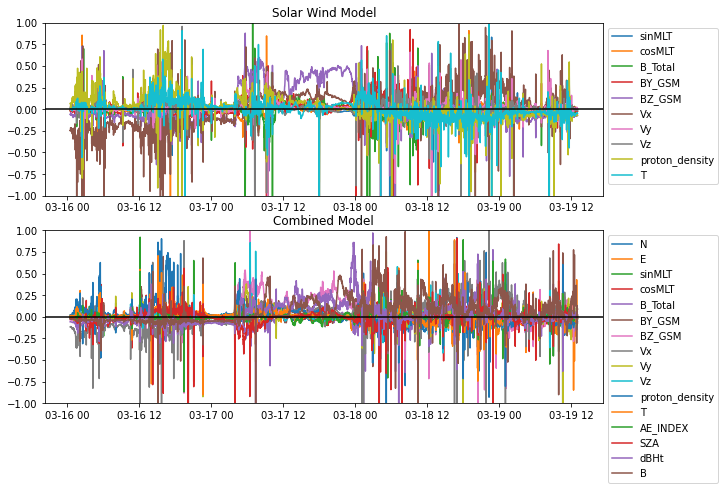

In [33]:
fig = plt.figure(figsize=(10,7))

ax1 = plt.subplot(211)
ax1.set_title('Solar Wind Model')
for col in sw_df:
	plt.plot(below_sw[col], label=col)
plt.axhline(0, color='black')
plt.ylim(-1,1)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

ax2 = plt.subplot(212)
ax2.set_title('Combined Model')
for col in combined_df:
	plt.plot(below_combined[col], label=col)
plt.axhline(0, color='black')
plt.ylim(-1,1)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()

In [34]:
perc_sw_df = (sw_df.abs().div(sw_df.abs().sum(axis=1), axis=0))*100
perc_combined_df = (combined_df.abs().div(combined_df.abs().sum(axis=1), axis=0))*100

prec_sw_x = perc_sw_df.index
prec_combined_x = perc_combined_df.index

perc_sw_df.reset_index(drop=True, inplace=True)
perc_combined_df.reset_index(drop=True, inplace=True)

perc_sw_dict, perc_combined_dict = {}, {}

for col in perc_sw_df:
	perc_sw_dict[col] = perc_sw_df[col].to_numpy()

for col in perc_combined_df:
	perc_combined_dict[col] = perc_combined_df[col].to_numpy()

perc_combined_dict = {k : perc_combined_dict[k] for k in ["sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   					"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T",
	   					 "AE_INDEX", "SZA", "N", "E", "B", "dBHt"]}


# print(perc_sw_dict)

In [35]:
sns.color_palette('tab20', 20)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

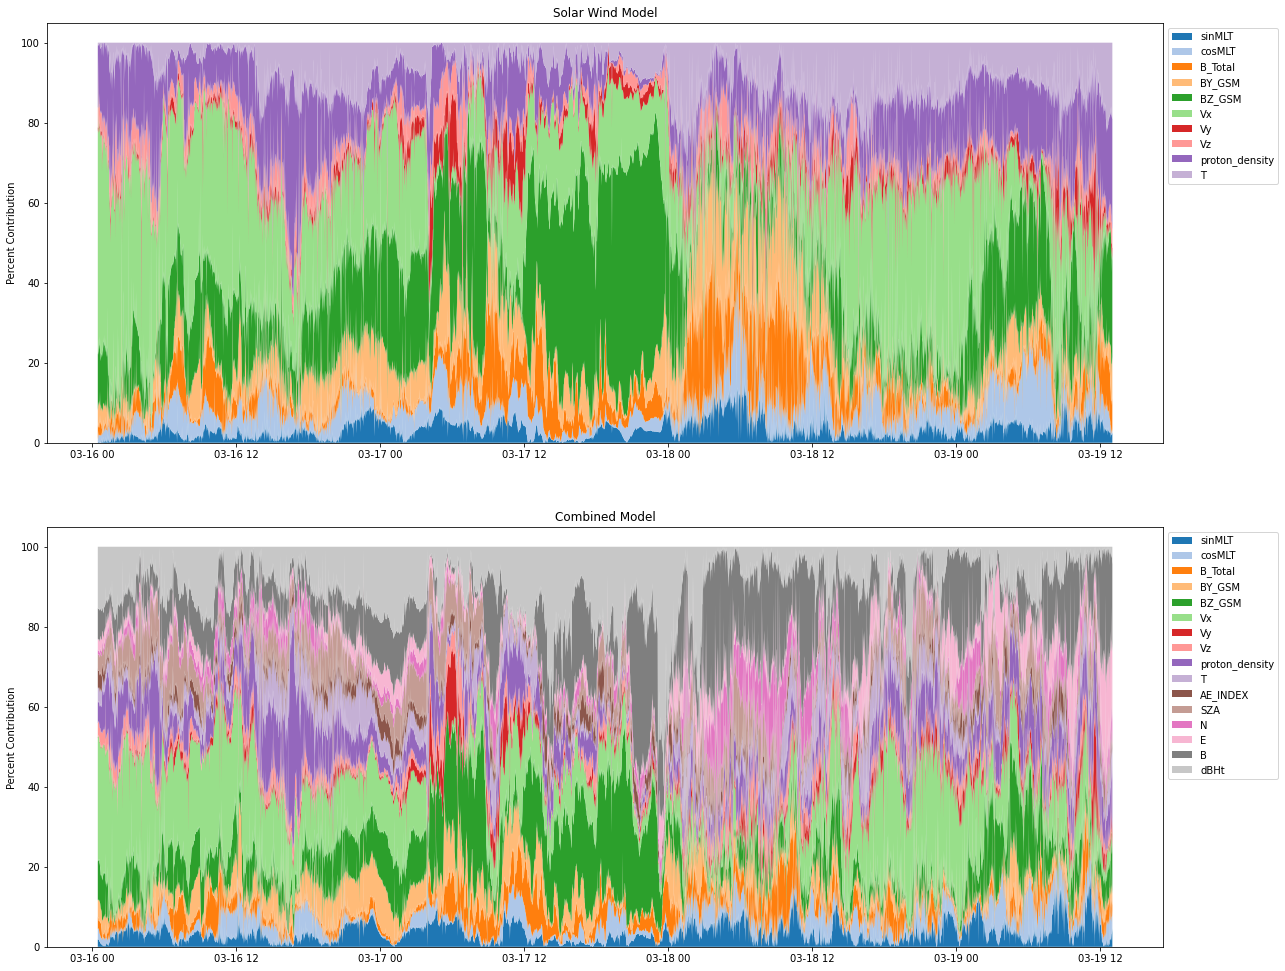

In [36]:


fig = plt.figure(figsize=(20,17))

ax1 = plt.subplot(211)
ax1.set_title('Solar Wind Model')
# for col in sw_df:
plt.stackplot(prec_sw_x, perc_sw_dict.values(), labels=perc_sw_dict.keys(), colors=sns.color_palette('tab20', len(perc_sw_dict.keys())))
plt.ylabel('Percent Contribution')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

ax2 = plt.subplot(212)
ax2.set_title('Combined Model')
plt.stackplot(prec_combined_x, perc_combined_dict.values(), labels=perc_combined_dict.keys(), colors=sns.color_palette('tab20', len(perc_combined_dict.keys())))
plt.ylabel('Percent Contribution')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()
# plt.savefig(f'plots/shap/percent_contribution_{station}_storm_{storm}_split_{model_split}.png')